#Univariate Time Series Classification

In [1]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from IPython import display
import seaborn as sn
import pandas as pd

In [2]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
#Reading both the datasets
normal = pd.read_csv('ptbdb_normal.csv',header = None)
abnormal = pd.read_csv('ptbdb_abnormal.csv', header = None)

In [4]:
data = pd.concat([normal, abnormal])

In [5]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.shape

(14552, 188)

In [7]:
n_classes = len(np.unique(data[187].value_counts()))
n_classes

2

In [8]:
#Extracting seq length and labels
X = data[data.columns[0:-1]].values
y = data[data.columns[-1]].values

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(11641, 187)
(2911, 187)


In [9]:
#Transform data into 3D (Batchsize, channels, seq_length)
N_train = X_train.shape[0]
channels = 1
seq_len = X_train.shape[1]
N_test = X_test.shape[0]

X_train = X_train.reshape(N_train, channels ,seq_len)
X_test = X_test.reshape(N_test, channels ,seq_len)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(11641, 1, 187)
(11641,)
(2911, 1, 187)
(2911,)


In [10]:
#Transform to tensor and use dataloader

# Convert to tensor
train_data = torch.tensor(X_train).float()
train_labels = torch.tensor(y_train).long()
test_data = torch.tensor(X_test).float()
test_labels = torch.tensor(y_test).long()


# Convert to PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Place into dataloader
batchsize    = 32
train_loader = DataLoader(train_data, batch_size = batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [11]:
#Train batch
for x,y in train_loader:
    break
print(x.shape)
print(y.shape)

torch.Size([32, 1, 187])
torch.Size([32])


In [12]:
#Test Batch
for x,y in test_loader:
    break
print(x.shape)
print(y.shape)

torch.Size([2911, 1, 187])
torch.Size([2911])


In [13]:
#Creating the model

model = nn.Sequential(nn.Conv1d(in_channels = 1, out_channels = 64, kernel_size = 5, stride = 1),
                      nn.ReLU(),
                      nn.Conv1d(in_channels = 64, out_channels = 128, kernel_size = 2, stride = 1),
                      nn.ReLU(),
                      nn.Conv1d(in_channels = 128, out_channels = 256, kernel_size = 4, stride = 1),
                      nn.ReLU(),
                      nn.MaxPool1d(2,2),
                      nn. Flatten(),
                      nn.LazyLinear(128),
                      nn.Linear(128,2)
                      )

In [14]:
#Training and testing

epochs = 51

# Loss function

lossfunc = nn.CrossEntropyLoss()

# optimizer

optimizer = torch.optim.SGD(model.parameters(), momentum = 0.9, lr = 0.01)

model.to(device) # placing a model on GPU

  # Initialize losses and Accuracies

losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


# loop over epochs

for epoch in range(epochs):
 model.train()

 # loop over training data batches

 batchAcc  = []
 batchLoss = []
 for X,y in train_loader:

  X = X.to(device) # Placing features on device
  y = y.to(device) # placing labels on device

  ypred = model(X)
  loss = lossfunc(ypred,y)


  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Append batchloss

  batchLoss.append(loss.item())

  ypred = ypred.cpu() # Back to cpu
  y = y.cpu()

  # compute batch accuracy

  acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
  batchAcc.append(acc)
# Batch loop concluded

# Average training accuracy (Outside the batchloop)

 trainAcc.append(np.mean(batchAcc))

# Losses through epochs

 losses[epoch] = np.mean(batchLoss)

# TESTING the model

 model.eval()

 with torch.no_grad():

    for X,y in test_loader:

            X = X.to(device)
            y = y.to(device)

            ypred =  model(X)
            ypred = ypred.cpu()
            y = y.cpu()


 # Appending test accuracy

 testAcc.append(100 * torch.mean((torch.argmax(ypred,dim=1)==y).float()))
 if (epoch % 10) == 0:

        print(f' epochs : {epoch}  loss : {loss}')


 epochs : 0  loss : 0.41174980998039246
 epochs : 10  loss : 0.03364300727844238
 epochs : 20  loss : 0.005133954342454672
 epochs : 30  loss : 0.03821047767996788
 epochs : 40  loss : 4.962585080647841e-05
 epochs : 50  loss : 0.00016143951506819576


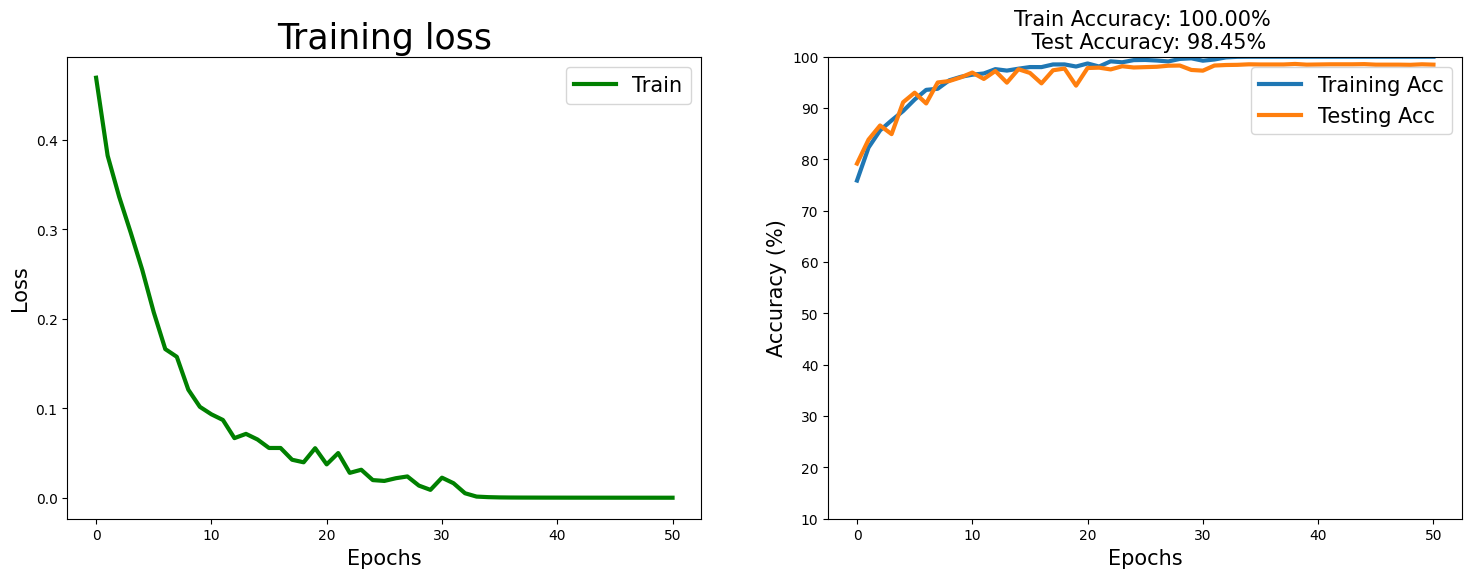

In [15]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses,'g', lw = 3)
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(['Train','Test'], fontsize = 15)
ax[0].set_title('Training loss', fontsize = 25)

ax[1].plot(trainAcc,label='Training Acc', lw =3)
ax[1].plot(testAcc,label='Testing Acc', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,100])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()